
# ✈️ AeroConnect Route Analytics & Forecasting

**Author:** Data Science Student  
**Date:** August 22, 2025

This notebook explores international route performance for AeroConnect and builds a short-term passenger forecast for selected routes.

## Objectives
1. **Understand the data**
   - Identify highest and lowest trafficked routes
   - Analyze trends and geographical patterns (ports, countries, seasonality)
2. **Build models**
   - Compare classic models (Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting)
   - Forecast passenger traffic for the next 6–12 months on at least one city pair
3. **Evaluate & recommend**
   - Explain model choices and report accuracy
   - Provide route/network recommendations and how to use the model going forward


## 1) Imports & Configuration

In [264]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 2) Load Data

In [265]:

dataPath = 'csv.csv'  # path to uploaded CSV
df = pd.read_csv(dataPath)
df.head()


,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
0,Jan-85,Adelaide,Auckland,New Zealand,1513,42.17,0.31,985,18.70,0.92,2498,60.87,1.24,1985,1
1,Jan-85,Adelaide,Bahrain,Bahrain,12,0.00,0.00,5,0.03,0.00,17,0.03,0.00,1985,1
2,Jan-85,Adelaide,Bombay,India,7,0.00,0.00,5,0.00,0.00,12,0.00,0.00,1985,1
3,Jan-85,Adelaide,Frankfurt,Germany,115,0.01,0.00,171,0.00,0.25,286,0.01,0.25,1985,1
4,Jan-85,Adelaide,London,UK,1567,2.80,0.00,1472,10.62,2.49,3039,13.42,2.49,1985,1


## 3) Initial Inspection

In [266]:

print(df.dtypes)
print("Duplicates:", df.duplicated().sum())
df.describe()


Month                      object
AustralianPort             object
ForeignPort                object
Country                    object
Passengers_In               int64
Freight_In_(tonnes)       float64
Mail_In_(tonnes)          float64
Passengers_Out              int64
Freight_Out_(tonnes)      float64
Mail_Out_(tonnes)         float64
Passengers_Total            int64
Freight_Total_(tonnes)    float64
Mail_Total_(tonnes)       float64
Year                        int64
Month_num                   int64
dtype: object
Duplicates: 0


,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
count,"9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00","9,999.00"
mean,"1,489.99",57.58,1.33,"1,439.84",66.32,2.07,"2,929.83",123.90,3.39,"1,986.86",6.20
std,"3,101.65",150.50,5.74,"3,065.38",165.84,6.49,"6,130.62",297.55,10.40,1.30,3.44
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"1,985.00",1.00
25%,45.00,0.00,0.00,51.00,0.00,0.00,100.00,0.05,0.00,"1,986.00",3.00
50%,333.00,2.12,0.00,324.00,5.20,0.01,664.00,13.10,0.04,"1,987.00",6.00
75%,"1,586.00",41.67,0.22,"1,535.50",58.67,1.06,"3,131.50",93.72,1.52,"1,988.00",9.00
max,"37,754.00","1,795.48",110.52,"38,475.00","1,899.03",103.11,"70,014.00","3,242.98",197.70,"1,989.00",12.00


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Month                   9999 non-null   object 
 1   AustralianPort          9999 non-null   object 
 2   ForeignPort             9999 non-null   object 
 3   Country                 9999 non-null   object 
 4   Passengers_In           9999 non-null   int64  
 5   Freight_In_(tonnes)     9999 non-null   float64
 6   Mail_In_(tonnes)        9999 non-null   float64
 7   Passengers_Out          9999 non-null   int64  
 8   Freight_Out_(tonnes)    9999 non-null   float64
 9   Mail_Out_(tonnes)       9999 non-null   float64
 10  Passengers_Total        9999 non-null   int64  
 11  Freight_Total_(tonnes)  9999 non-null   float64
 12  Mail_Total_(tonnes)     9999 non-null   float64
 13  Year                    9999 non-null   int64  
 14  Month_num               9999 non-null   

## 4) Cleaning & Feature Engineering

In [268]:

# Route column
df['route'] = df['AustralianPort'].str.strip().str.title() + ' - ' + df['ForeignPort'].str.strip().str.title()

# Standardize text columns
for col in ['AustralianPort','ForeignPort','Country']:
    df[col] = df[col].astype(str).str.strip().str.title()

# Create date field
df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_num'].astype(str), format='%Y-%m')

df.drop('Month',axis =1,inplace= True)

In [269]:
df = df[['date','Year','Month_num','route','AustralianPort','ForeignPort','Country','Passengers_In','Passengers_Out','Passengers_Total','Freight_In_(tonnes)','Freight_Out_(tonnes)','Freight_Total_(tonnes)','Mail_In_(tonnes)','Mail_Out_(tonnes)', 'Mail_Total_(tonnes)']]

In [270]:
df.head(5)

,date,Year,Month_num,route,AustralianPort,ForeignPort,Country,Passengers_In,Passengers_Out,Passengers_Total,Freight_In_(tonnes),Freight_Out_(tonnes),Freight_Total_(tonnes),Mail_In_(tonnes),Mail_Out_(tonnes),Mail_Total_(tonnes)
0,1985-01-01,1985,1,Adelaide - Auckland,Adelaide,Auckland,New Zealand,1513,985,2498,42.17,18.70,60.87,0.31,0.92,1.24
1,1985-01-01,1985,1,Adelaide - Bahrain,Adelaide,Bahrain,Bahrain,12,5,17,0.00,0.03,0.03,0.00,0.00,0.00
2,1985-01-01,1985,1,Adelaide - Bombay,Adelaide,Bombay,India,7,5,12,0.00,0.00,0.00,0.00,0.00,0.00
3,1985-01-01,1985,1,Adelaide - Frankfurt,Adelaide,Frankfurt,Germany,115,171,286,0.01,0.00,0.01,0.00,0.25,0.25
4,1985-01-01,1985,1,Adelaide - London,Adelaide,London,Uk,1567,1472,3039,2.80,10.62,13.42,0.00,2.49,2.49


In [271]:
invalid_passenger_rows = df[(df['Passengers_Total'] <= 0) | 
                            (df['Passengers_In'] < 0) | 
                            (df['Passengers_Out'] < 0)]

print(f"Invalid passenger rows: {len(invalid_passenger_rows)}")

Invalid passenger rows: 44


Top 10 Routes:
 route
Sydney - Auckland        2961212
Sydney - Singapore       1440018
Sydney - Tokyo           1292116
Sydney - Hong Kong       1151900
Perth - Singapore         952926
Brisbane - Auckland       893246
Sydney - Christchurch     882357
Melbourne - Singapore     865251
Sydney - Los Angeles      862964
Sydney - Honolulu         861814
Name: Passengers_Total, dtype: int64


/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/1492164080.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_routes.values, y=top_routes.index, palette='viridis')


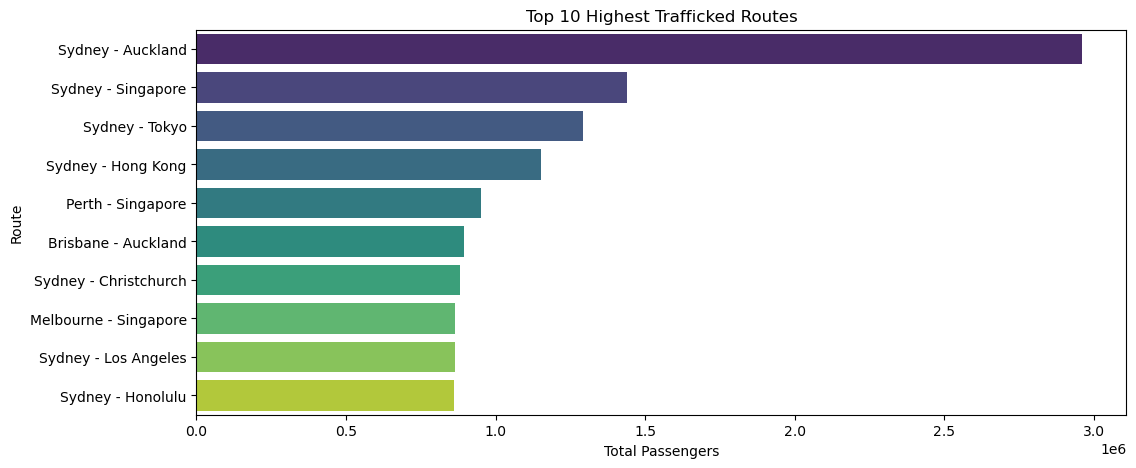

In [272]:
route_traffic = df.groupby('route')['Passengers_Total'].sum().sort_values(ascending=False)

# Top and bottom 10 routes
top_routes = route_traffic.head(10)

print("Top 10 Routes:\n", top_routes)

# Plotting
plt.figure(figsize=(12,5))
sns.barplot(x=top_routes.values, y=top_routes.index, palette='viridis')
plt.title("Top 10 Highest Trafficked Routes")
plt.xlabel("Total Passengers")
plt.ylabel("Route")
plt.show()


route
Hobart - Los Angeles           2
Hobart - Tokyo                 1
Cairns - Honiara               1
Townsville - San Francisco     1
Darwin - Zagreb                1
Melbourne - Denver             0
Perth - Bandar Seri Begawan    0
Brisbane - Colombo             0
Adelaide - Harare              0
Brisbane - Chicago             0
Name: Passengers_Total, dtype: int64
route
Darwin - Zagreb               1
Hobart - Tokyo                1
Townsville - San Francisco    1
Cairns - Honiara              1
Hobart - Los Angeles          2
Perth - Port Moresby          2
Adelaide - Jakarta            3
Hobart - Denpasar             3
Cairns - Belgrade             3
Cairns - Larnaca              4
Name: Passengers_Total, dtype: int64


/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/4105166928.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_routes_filtered.values, y=bottom_routes_filtered.index, palette='rocket')


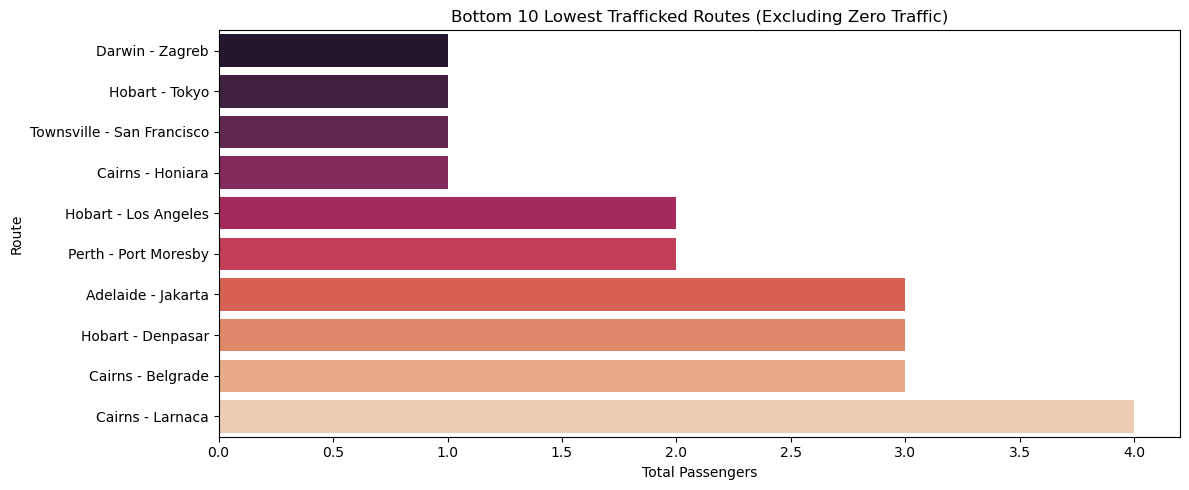

In [273]:
# Filter out routes with 0 total passengers before selecting bottom 10
nonzero_route_traffic = route_traffic[route_traffic > 0]
bottom_routes_filtered = nonzero_route_traffic.sort_values().head(10)

print(route_traffic.tail(10))
print(bottom_routes_filtered)

# Plot bottom 10 non-zero routes
plt.figure(figsize=(12, 5))
sns.barplot(x=bottom_routes_filtered.values, y=bottom_routes_filtered.index, palette='rocket')
plt.title("Bottom 10 Lowest Trafficked Routes (Excluding Zero Traffic)")
plt.xlabel("Total Passengers")
plt.ylabel("Route")
plt.tight_layout()
plt.show()



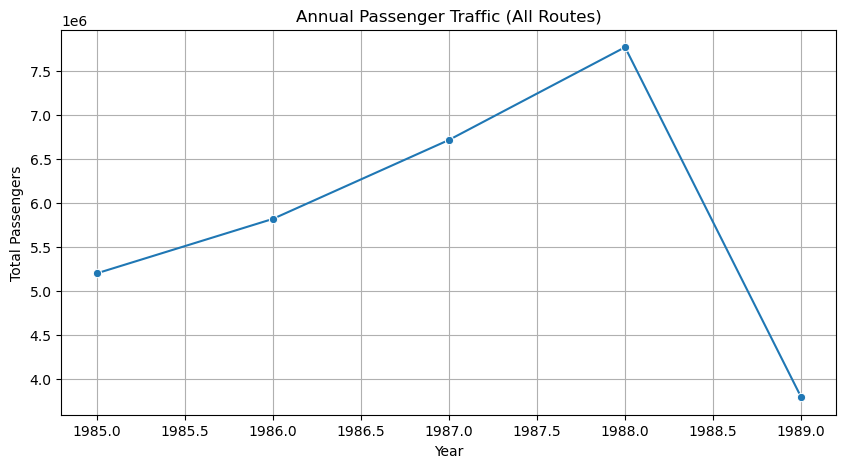

In [274]:
annual_traffic = df.groupby('Year')['Passengers_Total'].sum()

plt.figure(figsize=(10,5))
sns.lineplot(x=annual_traffic.index, y=annual_traffic.values, marker='o')
plt.title("Annual Passenger Traffic (All Routes)")
plt.ylabel("Total Passengers")
plt.xlabel("Year")
plt.grid(True)
plt.show()

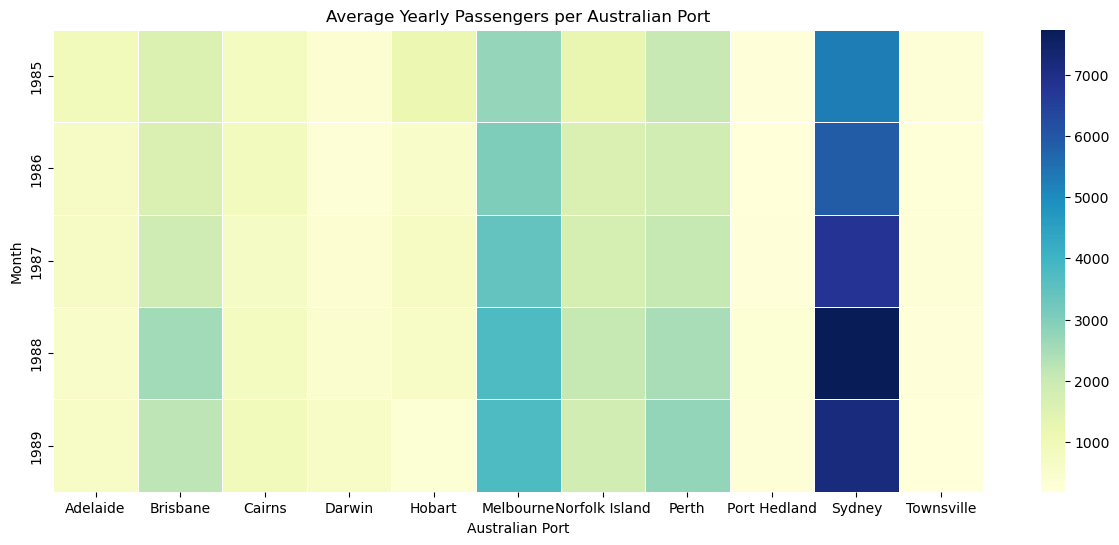

In [275]:
yearly_avg = df.groupby(['Year', 'AustralianPort'])['Passengers_Total'].mean().unstack()
plt.figure(figsize=(15,6))
sns.heatmap(yearly_avg, cmap="YlGnBu", linewidths=0.5)
plt.title("Average Yearly Passengers per Australian Port")
plt.xlabel("Australian Port")
plt.ylabel("Month")
plt.show()

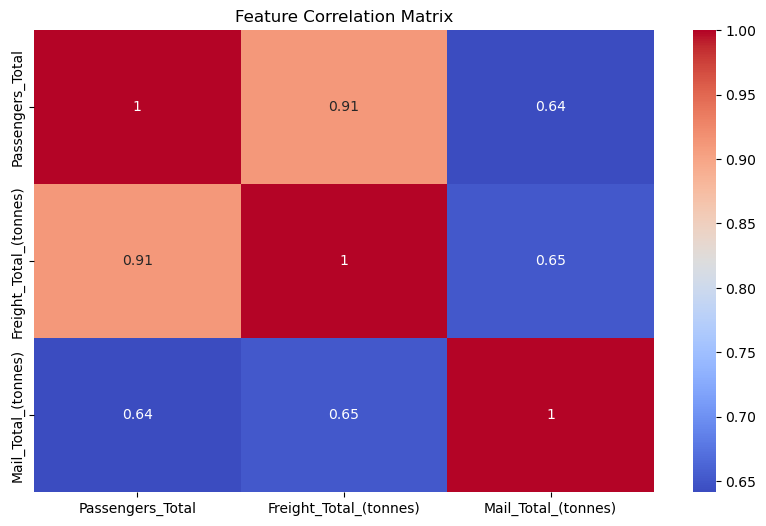

In [276]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Passengers_Total', 'Freight_Total_(tonnes)', 'Mail_Total_(tonnes)']].corr(), 
            annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

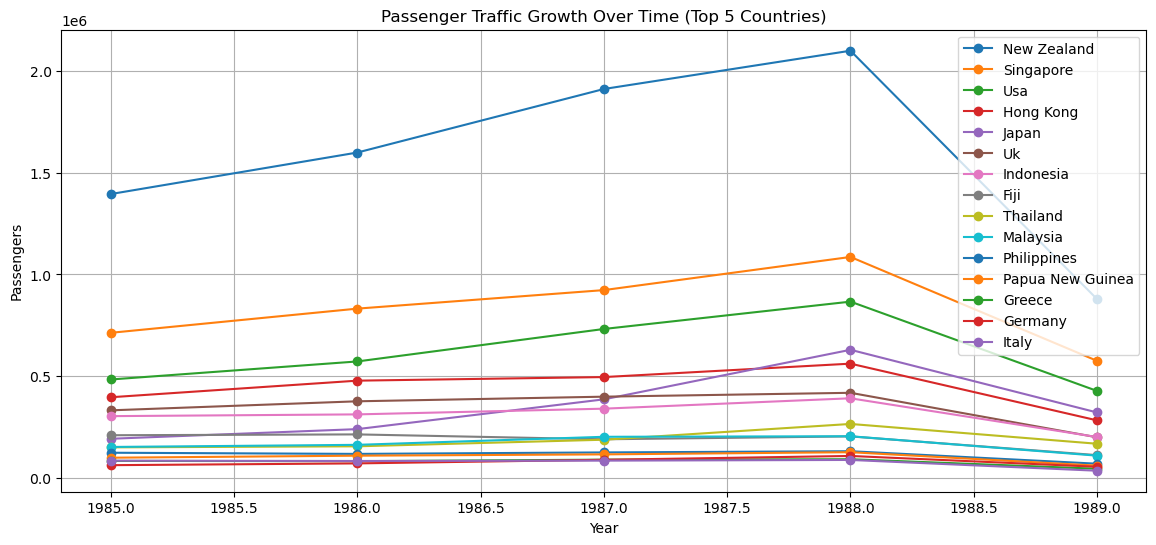

In [277]:
country_year = df.groupby(['Year','Country'])['Passengers_Total'].sum().reset_index()
country_traffic = df.groupby('Country')['Passengers_Total'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(14,6))
top_countries = country_traffic.index[:]  # top 5 countries
for c in country_traffic.index:
    subset = country_year[country_year['Country'] == c]
    plt.plot(subset['Year'], subset['Passengers_Total'], marker='o', label=c)

plt.title("Passenger Traffic Growth Over Time (Top 5 Countries)")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/3995281796.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_freight.values, y=country_freight.index, palette="mako")


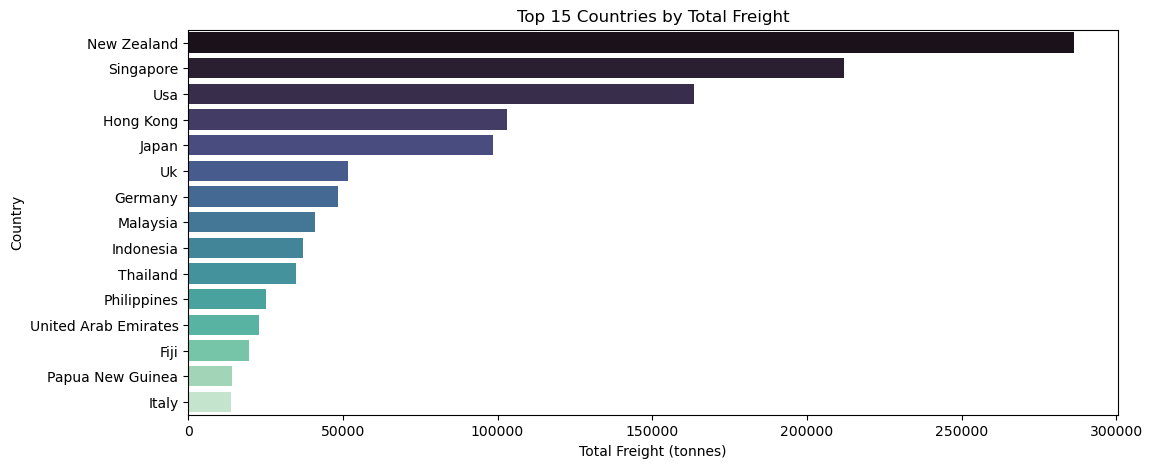

In [278]:
country_freight = df.groupby('Country')['Freight_Total_(tonnes)'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=country_freight.values, y=country_freight.index, palette="mako")
plt.title("Top 15 Countries by Total Freight")
plt.xlabel("Total Freight (tonnes)")
plt.ylabel("Country")
plt.show()

/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/1317873066.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_mail.values, y=country_mail.index, palette="rocket")


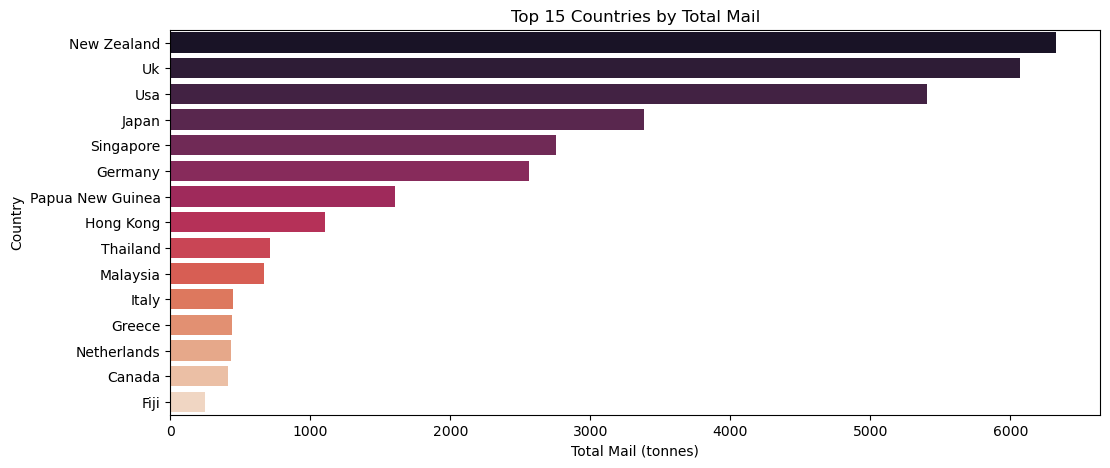

In [279]:
# --- 3. Mail by Country ---
country_mail = df.groupby('Country')['Mail_Total_(tonnes)'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=country_mail.values, y=country_mail.index, palette="rocket")
plt.title("Top 15 Countries by Total Mail")
plt.xlabel("Total Mail (tonnes)")
plt.ylabel("Country")
plt.show()

/var/folders/bb/hsp4zv4n1j90qvy7v635c_m40000gn/T/ipykernel_50629/766701626.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratio.values, y=ratio.index, palette="coolwarm")


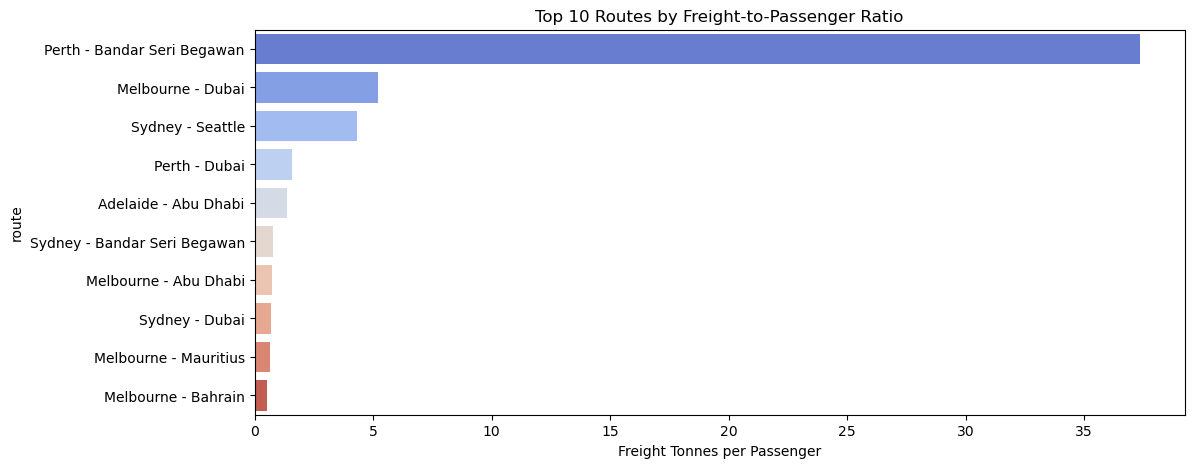

In [280]:
# --- 4. Freight to Passenger Ratio ---
df['Freight_per_Passenger'] = df['Freight_Total_(tonnes)'] / (df['Passengers_Total']+1)  # avoid div by 0
ratio = df.groupby('route')['Freight_per_Passenger'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,5))
sns.barplot(x=ratio.values, y=ratio.index, palette="coolwarm")
plt.title("Top 10 Routes by Freight-to-Passenger Ratio")
plt.xlabel("Freight Tonnes per Passenger")
plt.show()

In [281]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [282]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [283]:
top_route = df[df['route']=='Sydney - Auckland']
route_df = top_route.sort_values('date')

df_prophet = route_df[['date', 'Passengers_Total']].rename(columns={'date': 'ds', 'Passengers_Total': 'y'})
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(df_prophet)

03:06:14 - cmdstanpy - INFO - Chain [1] start processing
03:06:14 - cmdstanpy - INFO - Chain [1] done processing


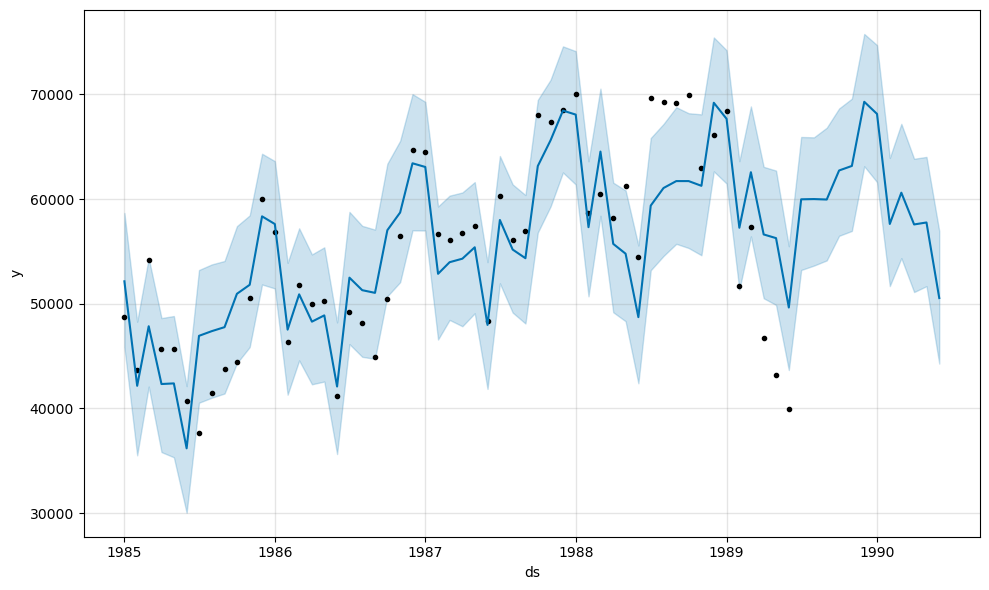

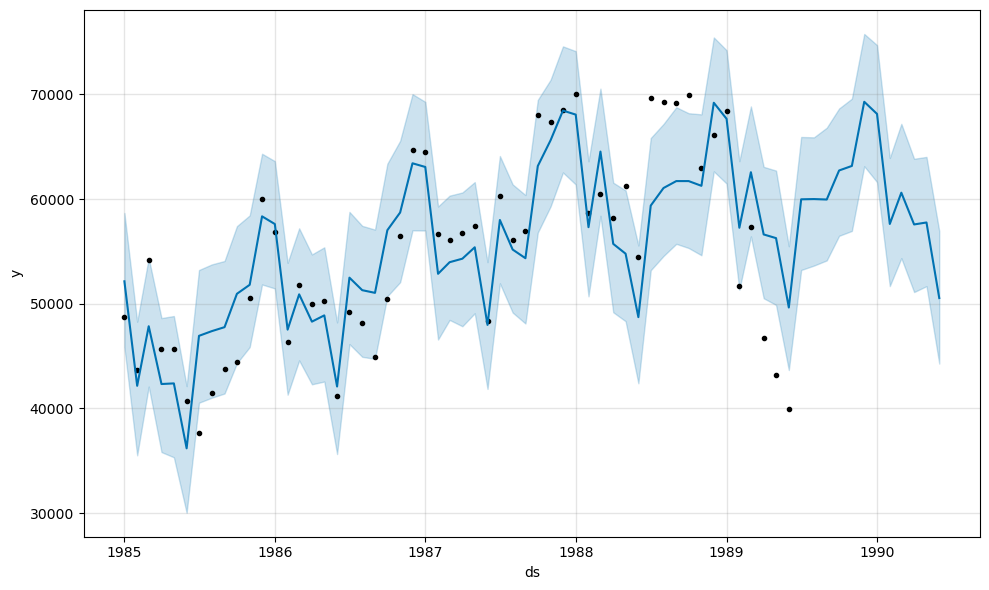

In [284]:
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
model.plot(forecast)

In [285]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))


           ds      yhat  yhat_lower  yhat_upper
54 1989-07-01 59,969.99   53,220.37   65,921.99
55 1989-08-01 59,993.33   53,642.17   65,887.03
56 1989-09-01 59,950.01   54,136.01   66,805.38
57 1989-10-01 62,723.17   56,485.28   68,642.80
58 1989-11-01 63,156.53   56,950.90   69,582.31
59 1989-12-01 69,281.57   63,125.68   75,758.56
60 1990-01-01 68,123.37   61,616.50   74,693.49
61 1990-02-01 57,616.89   51,683.42   63,920.92
62 1990-03-01 60,602.49   54,354.28   67,175.45
63 1990-04-01 57,570.38   51,115.38   63,841.27
64 1990-05-01 57,758.64   51,676.33   64,018.13
65 1990-06-01 50,542.18   44,285.46   56,944.09


In [286]:
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

# Calculate accuracy metrics (MAE, RMSE, etc.)
df_metrics = performance_metrics(df_cv)

# View metrics
print(df_metrics[['horizon', 'mae', 'rmse', 'mape']])


  0%|          | 0/3 [00:00<?, ?it/s]

03:06:15 - cmdstanpy - INFO - Chain [1] start processing
03:06:15 - cmdstanpy - INFO - Chain [1] done processing
03:06:15 - cmdstanpy - INFO - Chain [1] start processing
03:06:15 - cmdstanpy - INFO - Chain [1] done processing
03:06:15 - cmdstanpy - INFO - Chain [1] start processing
03:06:15 - cmdstanpy - INFO - Chain [1] done processing


    horizon       mae      rmse  mape
0   30 days  9,087.93 10,566.59  0.13
1   55 days  8,713.75 10,526.22  0.13
2   59 days  9,155.02 11,010.49  0.14
3   61 days  6,368.24  8,013.66  0.10
4   86 days  9,563.59  9,926.40  0.16
5   88 days 11,276.68 12,251.30  0.19
6   92 days 10,677.69 11,996.84  0.18
7  116 days 10,631.58 11,957.99  0.17
8  119 days  7,916.20  8,332.50  0.12
9  122 days 10,002.97 10,011.98  0.15
10 147 days  7,653.54  8,348.48  0.12
11 149 days  7,176.71  7,832.33  0.11
12 153 days  5,419.53  5,802.15  0.09
13 177 days  5,500.33  5,845.12  0.09
14 180 days  7,351.26  8,614.75  0.13
15 183 days 10,632.89 11,870.85  0.17
16 208 days 11,615.36 12,253.02  0.19
17 210 days 10,016.03 10,692.28  0.15
18 214 days  6,385.61  6,658.14  0.09
19 239 days  6,581.66  6,845.71  0.10
20 241 days  3,958.14  4,621.12  0.06
21 245 days  7,317.82  9,132.37  0.13
22 268 days  9,984.20 11,863.61  0.18
23 272 days 11,050.39 12,088.46  0.19
24 273 days 10,596.20 11,566.50  0.18
25 299 days 